# Experiment 5.1: LSTM-Based Univariate Time Series Forecasting

**Objective:**  
Forecast future values of a univariate time series using an LSTM model and evaluate performance with RMSE/MAE and prediction-vs-actual plots.

**Dataset:**  
Sunspots Time Series (downloaded automatically from TensorFlow utilities)


In [4]:
#@title 1. Install & Import Libraries
# !pip install tensorflow pandas scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


## 2. Load & Inspect Data


In [7]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
dataset_path = tf.keras.utils.get_file('daily-min-temperatures.csv', url)

df = pd.read_csv(dataset_path)
df.head()


67921/67921 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


## 3. Preprocess: Scaling & Windowing
- Scale values to [0,1]
- Frame as supervised learning with look-back window


In [8]:
# focus on 'Sunspots' column
series = df['Temp'].values

# scale to [0,1]
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1))

# create input-output windows
def create_windows(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps, 0])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_windows(series_scaled, n_steps)

# reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


## 4. Train/Test Split


In [10]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 5. Build & Compile LSTM Model


In [11]:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Model


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)


Epoch 1/50
82/82 - 4s - 45ms/step - loss: 0.0239 - val_loss: 0.0111
Epoch 2/50
82/82 - 3s - 33ms/step - loss: 0.0116 - val_loss: 0.0107
Epoch 3/50
82/82 - 1s - 16ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 4/50
82/82 - 1s - 15ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 5/50
82/82 - 1s - 14ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 6/50
82/82 - 1s - 15ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 7/50
82/82 - 1s - 17ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 8/50
82/82 - 2s - 30ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 9/50
82/82 - 1s - 15ms/step - loss: 0.0101 - val_loss: 0.0099
Epoch 10/50
82/82 - 2s - 20ms/step - loss: 0.0099 - val_loss: 0.0097
Epoch 11/50
82/82 - 3s - 42ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 12/50
82/82 - 4s - 53ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 13/50
82/82 - 2s - 25ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 14/50
82/82 - 3s - 37ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 15/50
82/82 - 3s - 36ms/step - loss: 

## 7. Forecast & Invert Scaling


In [13]:
y_pred = model.predict(X_test)

# invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


## 8. Evaluate Performance


In [14]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f'RMSE: {rmse:.3f}, MAE: {mae:.3f}')


RMSE: 2.203, MAE: 1.733


## 9. Plot: Prediction vs Actual


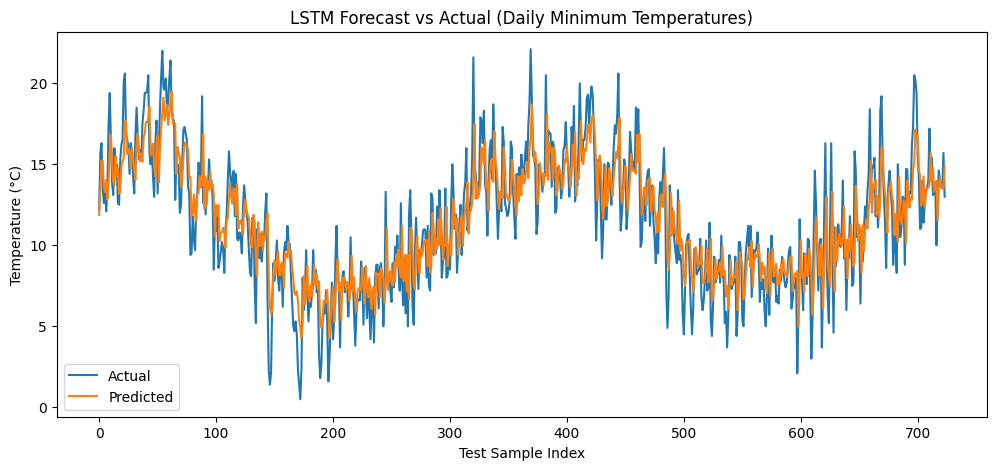

In [15]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Forecast vs Actual (Daily Minimum Temperatures)')
plt.xlabel('Test Sample Index')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()
